In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import math 

In [ ]:
# Load dataset
df = pd.read_csv("Groceries_dataset.csv")

df["itemDescription"].value_counts().head(10)

itemDescription
whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: count, dtype: int64

In [8]:
basket = (df.groupby(['Member_number','itemDescription'])['Date'].count().unstack().reset_index().fillna(0).set_index('Member_number'))

def encode_units(x):
    if x < 1:
        return 0
    if x >= 1:
        return 1


basket = basket.map(encode_units)
basket.head(10)

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
def apriori(basket_df, min_support=0.01, min_confidence=0.5):
    """
    Parameters:
    - basket_df: DataFrame (1 = purchased, 0 = not purchased)
    - min_support: minimum support threshold for frequent itemsets
    - min_confidence: minimum confidence for association rules

    Returns:
    - rules_df: DataFrame with association rules (antecedent, consequent, support, confidence, lift)
    """

    num_transactions = len(basket_df)
    support_threshold = min_support * num_transactions

    # Step 1: Generate 1-itemsets
    item_support = basket_df.sum().to_dict()
    frequent_itemsets = [{item} for item, count in item_support.items() if count >= support_threshold]
    itemset_support = {frozenset([item]): count for item, count in item_support.items() if count >= support_threshold}

    all_frequent_itemsets = dict(itemset_support)

    k = 2
    while True:
        # Convert each frozenset back to set before union
        candidate_items = set().union(*[set(fs) for fs in frequent_itemsets])
        candidate_itemsets = list(combinations(candidate_items, k))
        candidate_itemsets = [frozenset(itemset) for itemset in candidate_itemsets]

        # Remove duplicates
        candidate_itemsets = list(set(candidate_itemsets))

        # Count support
        itemset_counts = {}
        for itemset in candidate_itemsets:
            mask = basket_df[list(itemset)].all(axis=1)
            count = mask.sum()
            if count >= support_threshold:
                itemset_counts[itemset] = count

        if not itemset_counts:
            break

        all_frequent_itemsets.update(itemset_counts)
        frequent_itemsets = list(itemset_counts.keys())
        k += 1

    # Step 2: Generate association rules
    rules = []
    for itemset, support_count in all_frequent_itemsets.items():
        if len(itemset) < 2:
            continue
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent
                if not consequent:
                    continue
                antecedent_support = all_frequent_itemsets.get(antecedent, 0)
                consequent_support = all_frequent_itemsets.get(consequent, 0)
                confidence = support_count / antecedent_support if antecedent_support else 0
                lift = (confidence / (consequent_support / num_transactions)) if consequent_support else 0
                support = support_count / num_transactions

                if confidence >= min_confidence:
                    rules.append({
                        'antecedent': set(antecedent),
                        'consequent': set(consequent),
                        'support': support,
                        'confidence': confidence,
                        'lift': lift
                    })

    rules_df = pd.DataFrame(rules)
    return rules_df

In [31]:
rules_df = apriori(basket, min_support=0.02, min_confidence=0.6)
print(rules_df.sort_values(by='lift', ascending=False).head())

                                   antecedent    consequent   support  \
27  {bottled water, yogurt, other vegetables}  {whole milk}  0.022063   
17              {bottled beer, shopping bags}  {whole milk}  0.020010   
32     {rolls/buns, yogurt, other vegetables}  {whole milk}  0.034377   
0                {canned beer, shopping bags}  {whole milk}  0.022063   
29           {soda, yogurt, other vegetables}  {whole milk}  0.027963   

    confidence      lift  
27    0.682540  1.489664  
17    0.661017  1.442690  
32    0.656863  1.433623  
0     0.656489  1.432806  
29    0.648810  1.416047  


In [ ]:
# Plots top association rules by support
def plot_top_frequent_itemsets(rules_df, top_n=10):
    # Combine antecedent and consequent to form itemset label
    rules_df['itemset'] = rules_df['antecedent'].apply(lambda x: ', '.join(sorted(x))) + \
                          ' → ' + \
                          rules_df['consequent'].apply(lambda x: ', '.join(sorted(x)))

    # Drop duplicates (optional, if needed)
    rules_df_unique = rules_df.drop_duplicates(subset=['itemset'])

    # Sort by support
    top_rules = rules_df_unique.sort_values(by='support', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_rules['itemset'], top_rules['support'], color='mediumseagreen')
    plt.xlabel('Support')
    plt.title(f'Top {top_n} Association Rules by Support')
    plt.gca().invert_yaxis()  # Highest on top

    # Annotate bars
    for bar in bars:
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.4f}', va='center')

    plt.tight_layout()
    plt.show()

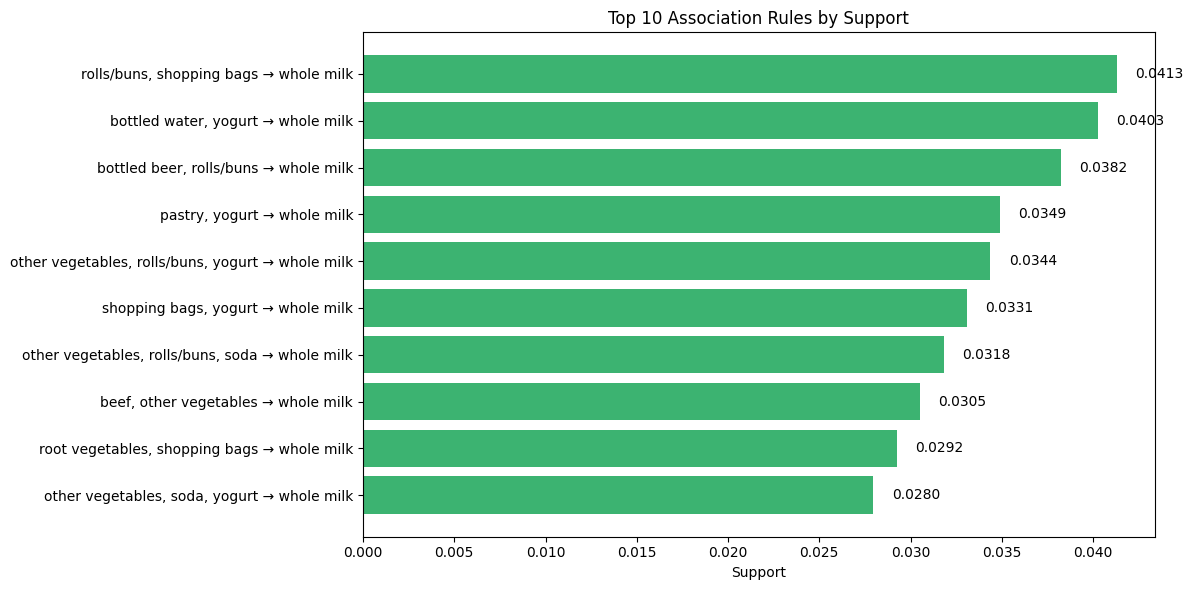

In [35]:
plot_top_frequent_itemsets(rules_df, top_n=10)

In [ ]:
# Plots top association rules by lift
def plot_top_rules_by_lift(rules_df, top_n=10):
    # Combine antecedent and consequent to form readable labels
    rules_df['itemset'] = rules_df['antecedent'].apply(lambda x: ', '.join(sorted(x))) + \
                          ' → ' + \
                          rules_df['consequent'].apply(lambda x: ', '.join(sorted(x)))

    # Drop duplicate rules (optional)
    rules_df_unique = rules_df.drop_duplicates(subset=['itemset'])

    # Sort by lift
    top_rules = rules_df_unique.sort_values(by='lift', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_rules['itemset'], top_rules['lift'], color='cornflowerblue')
    plt.xlabel('Lift')
    plt.title(f'Top {top_n} Association Rules by Lift')
    plt.gca().invert_yaxis()  # Highest lift at the top

    # Annotate lift values
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.2f}', va='center')

    plt.tight_layout()
    plt.show()

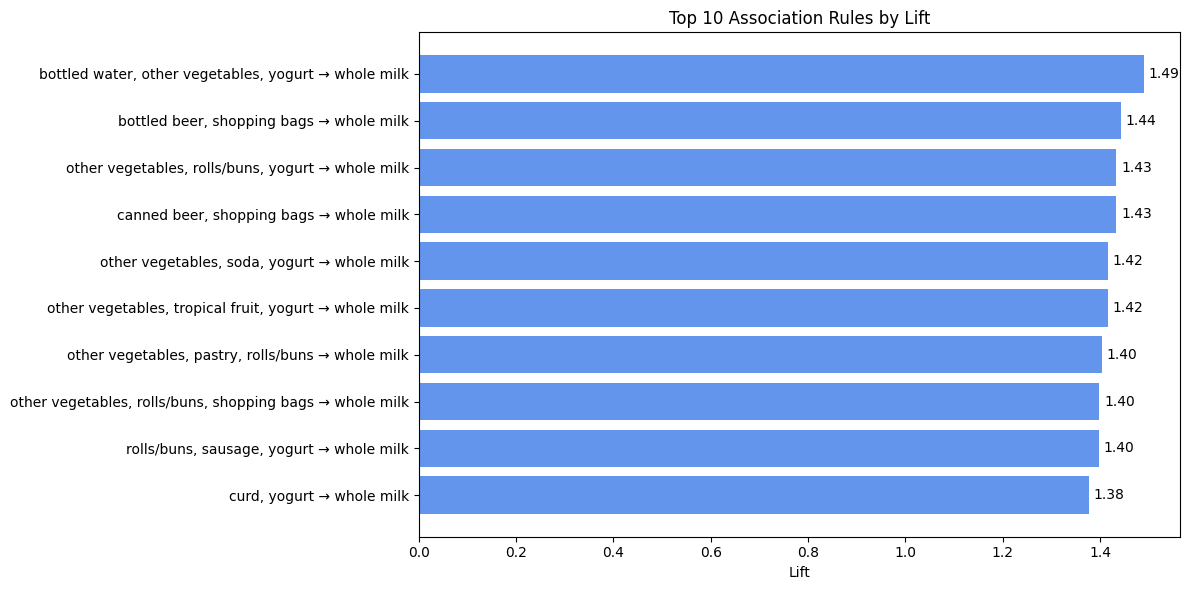

In [20]:
plot_top_rules_by_lift(rules_df, top_n=10)